In [1]:
import pandas as pd 
import geopandas as gpd
from scipy.io import mmread
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt 

# Toronto 

In [118]:
traffic_toronto = gpd.read_file("Data/2019-04-01-Toronto.geojson")
traffic_toronto = traffic_toronto.iloc[1:]

In [119]:
traffic_toronto = traffic_toronto.drop(["jobName", "creationTime", "userPreference", "dateRanges", "timeSets", "networkName", "zoneId", "probeSource", "segmentId"], axis = 1)

In [117]:
traffic_toronto.head()

,segmentId,newSegmentId,speedLimit,frc,streetName,distance,segmentTimeResults,geometry
1,-2.169083e+18,-0000434f-5000-0400-0000-000000a7daf6,60.0,3.0,Steeles Ave W,46.29,"[ { ""timeSet"": 2, ""dateRange"": 1, ""harmonicAve...","LINESTRING (-79.52444 43.77480, -79.52388 43.7..."
2,-2.169083e+18,-0000434f-5000-0400-0000-000000a7daff,60.0,3.0,Steeles Ave W,59.18,"[ { ""timeSet"": 2, ""dateRange"": 1, ""harmonicAve...","LINESTRING (-79.46387 43.78851, -79.46316 43.7..."
3,-2.169364e+18,-0000434f-5000-0400-0000-000000a7db02,60.0,4.0,Steeles Ave E,52.77,"[ { ""timeSet"": 2, ""dateRange"": 1, ""harmonicAve...","LINESTRING (-79.30009 43.82530, -79.30072 43.8..."
4,-2.169083e+18,-0000434f-5000-0400-0000-000000a7db0d,60.0,3.0,Steeles Ave W,36.22,"[ { ""timeSet"": 2, ""dateRange"": 1, ""harmonicAve...","LINESTRING (-79.53222 43.77324, -79.53211 43.7..."
5,-2.168801e+18,-0000434f-5000-0400-0000-000000a7db18,60.0,3.0,Steeles Ave W,49.58,"[ { ""timeSet"": 2, ""dateRange"": 1, ""harmonicAve...","LINESTRING (-79.63014 43.75182, -79.62955 43.7..."


In [116]:
traffic_toronto.segmentTimeResults[1]

'[ { "timeSet": 2, "dateRange": 1, "harmonicAverageSpeed": 16.820000, "medianSpeed": 31.200000, "averageSpeed": 32.780000, "standardDeviationSpeed": 19.390000, "travelTimeStandardDeviation": 15.410000, "sampleSize": 1772, "averageTravelTime": 9.910000, "medianTravelTime": 5.340000, "travelTimeRatio": 1.000000, "speedPercentiles": [ 5, 7, 9, 14, 18, 21, 24, 28, 29, 31, 32, 32, 37, 47, 50, 54, 57, 57, 64 ] } ]'

# Turin

In [26]:
# http://polygons.openstreetmap.fr/index.py?id=43992 , polygon creation from osm id (turin = 43992)
boundary_turin = gpd.read_file("Data/nord-ovest-latest-free.shp/boundary_turin.geojson")
#bbox = boundary_turin.envelope 
#df_bbox = gpd.GeoDataFrame(gpd.GeoSeries(bbox), columns = ["geometry"])
#intersections = gpd.overlay(df_bbox, DF_roads_turin, how = "intersection")

In [70]:
# bbox = (7.25,44.8,8.1,45.4)
DF_roads_turin = gpd.read_file("Data/nord-ovest-latest-free.shp/gis_osm_roads_free_1.shp", bbox = boundary_turin)
DF_buildings_turin = gpd.read_file("Data/nord-ovest-latest-free.shp/gis_osm_buildings_a_free_1.shp", bbox = boundary_turin)
# ferrovie di treni e tram
DF_railway_turin = gpd.read_file("Data/nord-ovest-latest-free.shp/gis_osm_railways_free_1.shp", bbox = boundary_turin)
#parcheggi, anche multipiano
DF_parking_turin = gpd.read_file("Data/nord-ovest-latest-free.shp/gis_osm_traffic_a_free_1.shp", bbox = boundary_turin)

# suburbs --> nella parte di sincronizzazione tra le misure restrittive, effetti lockdown 
DF_suburbs_turin =  gpd.read_file("Data/nord-ovest-latest-free.shp/gis_osm_places_a_free_1.shp", bbox = boundary_turin)
# just in case
DF_churches_turin = gpd.read_file("Data/nord-ovest-latest-free.shp/gis_osm_pofw_a_free_1.shp", bbox = boundary_turin)
# ospedali, parchi, teatri 
DF_public_places_turin = gpd.read_file("Data/nord-ovest-latest-free.shp/gis_osm_pois_a_free_1.shp", bbox = boundary_turin)
# DF_public_places_turin[DF_public_places_turin.fclass == "hospital"]
# stazioni ferroviarie, fermate bus, tram, traghetto (lol?), taxi 
DF_transport_turin = gpd.read_file("Data/nord-ovest-latest-free.shp/gis_osm_transport_a_free_1.shp", bbox = boundary_turin)

In [99]:
DF_roads_turin.to_file("Data/Turin_final/Roads_Turin.shp")
DF_buildings_turin.to_file("Data/Turin_final/Buildings_Turin.shp")

In [100]:
DF_public_places_turin[DF_public_places_turin.fclass == "hospital"].to_file("Data/Turin_final/Hospitals_Turin.shp")

In [41]:
print(DF_roads_turin.shape)
print(DF_buildings_turin.shape)
print(DF_railway_turin.shape)
print(DF_parking_turin.shape)

(27884, 11)
(37848, 6)
(1845, 8)
(1016, 5)


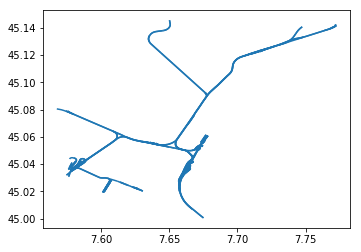

In [90]:
DF_railway_turin[DF_railway_turin.fclass == "rail"].plot()

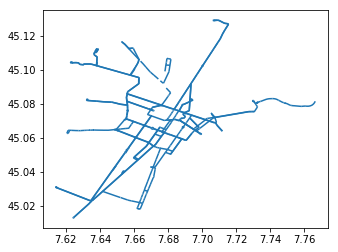

In [91]:
DF_railway_turin[DF_railway_turin.fclass == "tram"].plot()

In [101]:
# matplotlib qt permette di avere una figura interattiva
%matplotlib qt

#%matplotlib inline

fig, ax = plt.subplots(figsize=(20, 20))
DF_roads_turin.plot(ax = ax, alpha = 0.4, color = "black")
DF_buildings_turin.plot(ax = ax, alpha = 0.8, color = "orange")
DF_public_places_turin.plot(ax = ax , alpha = 0.6, color = "pink")
DF_parking_turin.plot(ax = ax, alpha = 0.7, color = "blue")
DF_churches_turin.plot(ax = ax, alpha = 0.7, color = "green")
DF_railway_turin.plot(ax = ax, alpha = 0.4, color = "red")
ax.set_xlim([7.56, 7.78])
ax.set_ylim([45, 45.155])

(45, 45.155)